In [ ]:
from expectation.seqtest.sequential_e_testing import SequentialTest
from expectation.utils.helper_functions import plot_sequential_test

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Initialize quantile test for median
quantile_test = SequentialTest(
    test_type="quantile",
    null_value=0,
    quantile=0.5,  # testing median
    alternative="two_sided"
)

In [3]:
# Simulation parameters
n_batches = 30
batch_size = 10
change_point = 15  # when distribution changes

In [4]:
results = []
batch_medians = []
data_distribution = []


# Simulate data with changing distribution
for batch in range(n_batches):
    # Generate batch with distribution shift after change_point
    if batch < change_point:
        batch_data = np.random.normal(0, 1, size=batch_size)  # null distribution
        data_distribution.append('Null')
    else:
        batch_data = np.random.normal(0.5, 1.2, size=batch_size)  # alternative
        data_distribution.append('Alternative')
    
    batch_medians.append(np.median(batch_data))
    
    # Update test
    result = quantile_test.update(batch_data)
    
    results.append({
        'batch': batch + 1,
        'batch_median': np.median(batch_data),
        'e_value': result.e_value,
        'cumulative_e_value': result.e_process.cumulative_value,
        'reject_null': result.reject_null,
        'p_value': result.p_value,
        'sample_size': result.sample_size,
        'distribution': data_distribution[-1]
    })

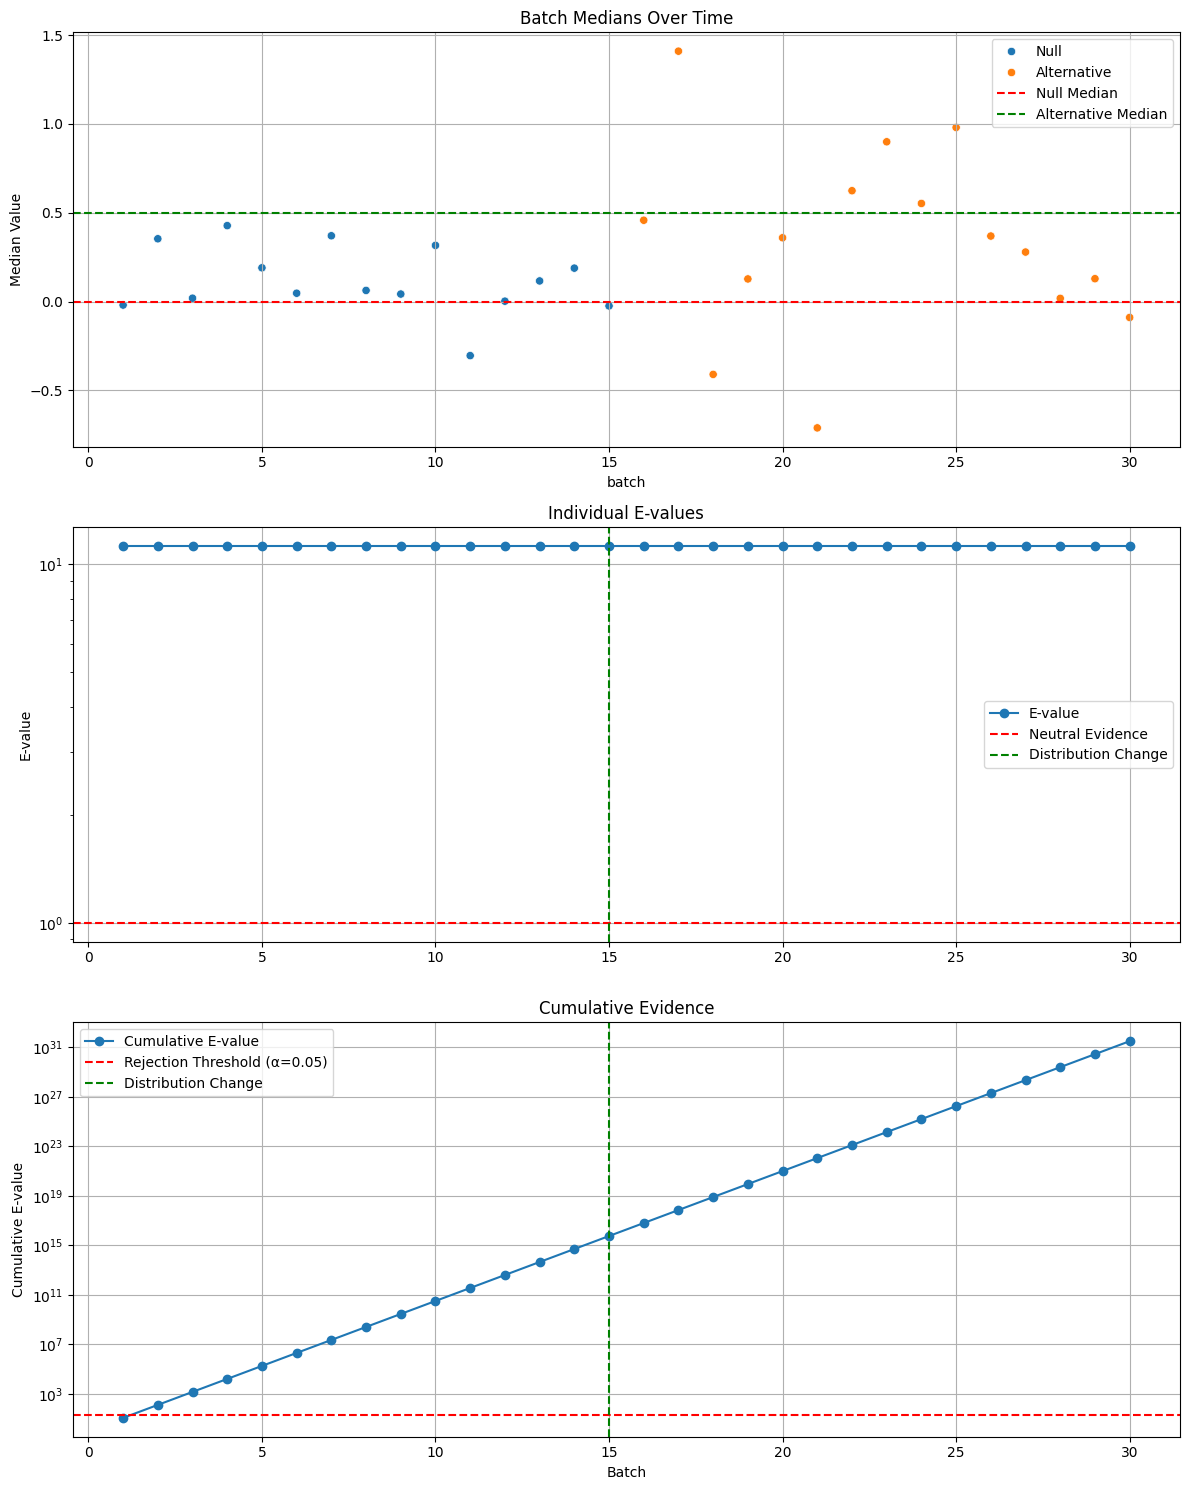


Quantile Test Summary:
Total samples analyzed: 300
True change point: Batch 15
Change detected at batch 2
Detection delay: -13 batches


In [5]:
# Create visualization
history_df = pd.DataFrame(results)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot 1: Batch Medians
sns.scatterplot(data=history_df, x='batch', y='batch_median', 
                hue='distribution', ax=ax1)
ax1.axhline(y=0, color='r', linestyle='--', label='Null Median')
ax1.axhline(y=0.5, color='g', linestyle='--', label='Alternative Median')
ax1.set_title('Batch Medians Over Time')
ax1.set_ylabel('Median Value')
ax1.legend()
ax1.grid(True)

# Plot 2: Individual E-values
ax2.plot(history_df['batch'], history_df['e_value'], 
         marker='o', label='E-value')
ax2.axhline(y=1, color='r', linestyle='--', label='Neutral Evidence')
ax2.axvline(x=change_point, color='g', linestyle='--', 
            label='Distribution Change')
ax2.set_title('Individual E-values')
ax2.set_ylabel('E-value')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

# Plot 3: Cumulative Evidence
ax3.plot(history_df['batch'], history_df['cumulative_e_value'], 
         marker='o', label='Cumulative E-value')
ax3.axhline(y=20, color='r', linestyle='--', 
            label='Rejection Threshold (α=0.05)')
ax3.axvline(x=change_point, color='g', linestyle='--', 
            label='Distribution Change')
ax3.set_title('Cumulative Evidence')
ax3.set_ylabel('Cumulative E-value')
ax3.set_xlabel('Batch')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print detection summary
first_detection = history_df[history_df['reject_null']].iloc[0] \
    if any(history_df['reject_null']) else None

print("\nQuantile Test Summary:")
print(f"Total samples analyzed: {history_df['sample_size'].iloc[-1]}")
print(f"True change point: Batch {change_point}")
if first_detection is not None:
    detection_delay = first_detection['batch'] - change_point
    print(f"Change detected at batch {first_detection['batch']}")
    print(f"Detection delay: {detection_delay} batches")
else:
    print("No change detected")

(<Figure size 1500x1000 with 3 Axes>,
 (<Axes: title={'center': 'Individual E-values'}, xlabel='Step', ylabel='E-value'>,
  <Axes: title={'center': 'Cumulative E-values (E-Process)'}, xlabel='Step', ylabel='Cumulative E-value'>,
  <Axes: title={'center': 'Raw Observations'}, xlabel='Step', ylabel='Value'>))

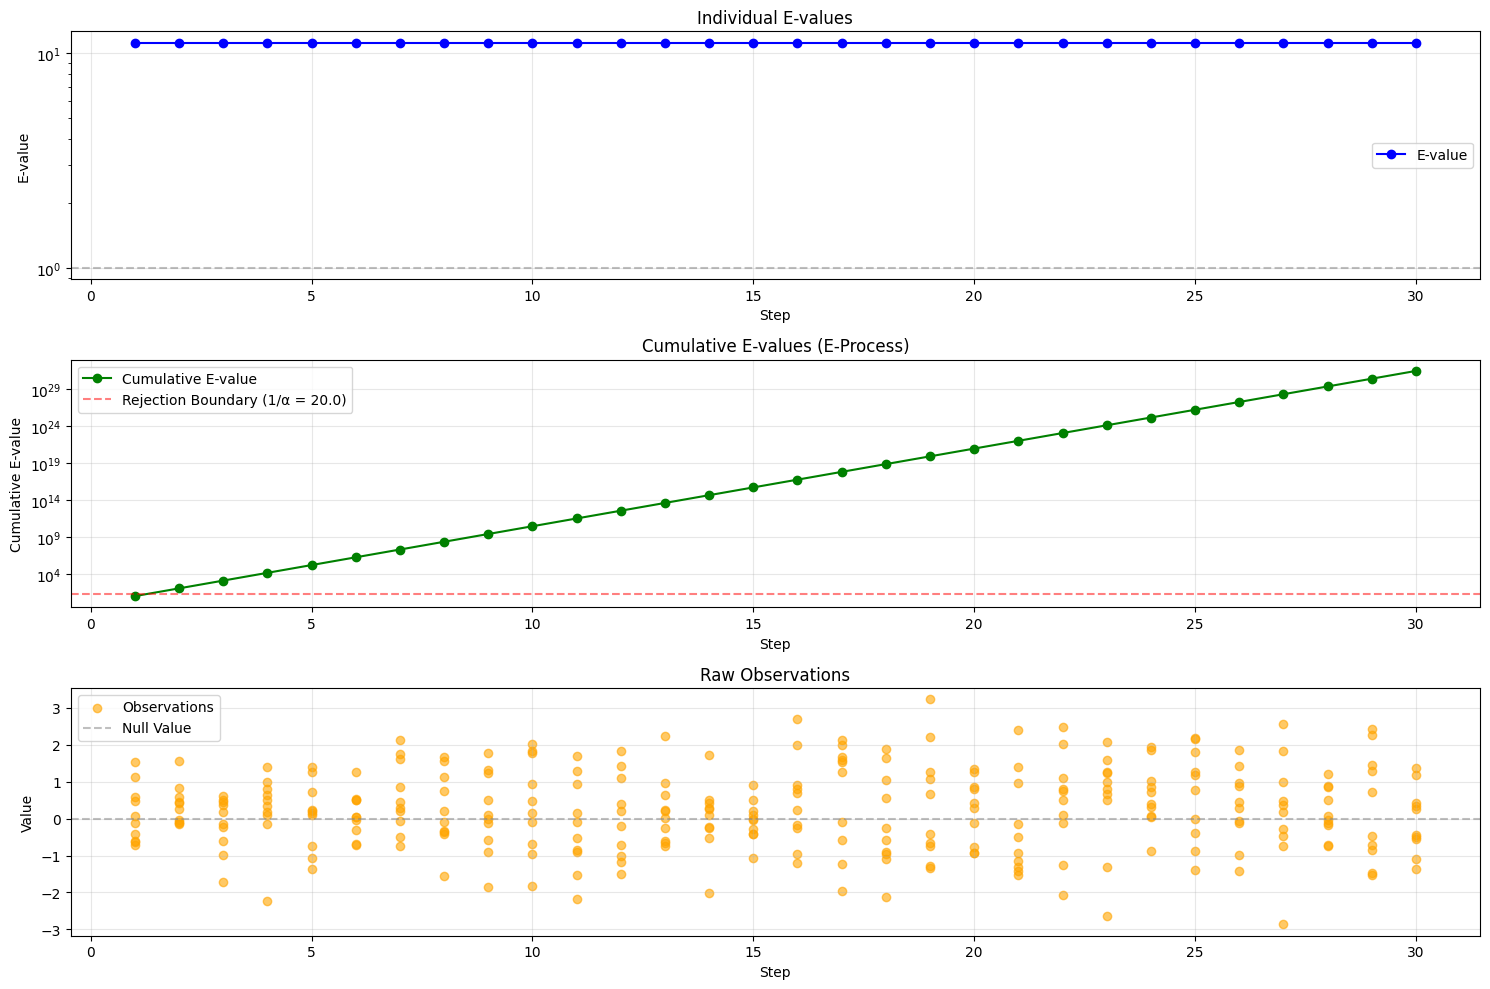

In [7]:
plot_sequential_test(quantile_test.get_history_df(), log=True)